# Preprocessing -- lotsa in vitro cells

We stimulated single cells as in P1902 and 3128 etc… in vitro and grew large clonal populations.  Here the clones P1 and P2 and P3 are unrelated expansions where we were able to sort large numbers of cells for scRNAseq.  We also have some in vivo cells.

The data were generated with smart-seq3 which is a more sensitive version of the old method we used in all other datasets we have (besides MR - that is 10x kits)

In [1]:
import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
import statsmodels.api as sm

from IPython.display import display # Pretty display of data frames.

# Import various functions for stats.
import scipy.stats as ss
from scipy.stats import f_oneway, binom, binom_test, kruskal, norm # For p-values, kruskal-wallis, Gaussian
from scipy.stats import kurtosis, skew, zscore # For detecting bimodality
import scipy.cluster.hierarchy as sch # For hierarchical clustering.

from statsmodels.formula.api import ols

from bisect import bisect # See bisect.bisect.
from itertools import compress # Nice way to apply masks to lists, etc.


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Import from scikit, for machine learning.
# from sklearn import mixture  # Import Gaussian mixture

from sklearn import base
from sklearn.preprocessing import Binarizer, MinMaxScaler
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB # Naive Bayes Classifiers.
from sklearn.ensemble import VotingClassifier # Voting classifier.
from sklearn.svm import LinearSVC, NuSVC, SVC # Support Vector Machine 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.manifold import TSNE

from sklearn.decomposition import PCA
import umap

import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Put plots inline rather than in a pop-up.
%matplotlib inline

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
file_prefix = 'Processed/'
file_suffix = '.loom'  

# Loading data


## Getting gene data



In [3]:
def get_genes(filename, verbose=True):
    gene_raw = pd.read_csv(filename, sep='\t', index_col=0, header=0, low_memory=False)
    #gene_raw.columns = ['transcript_length', 'gene_name', 'GC_content','transcript stable ID', 'TSS']
    if verbose:
        print('{} genes found in {}.'.format(len(gene_raw), filename))
    
    gene_lengths = gene_raw['Transcript length (including UTRs and CDS)'].groupby(gene_raw.index).mean()
    gene_GCs = gene_raw['Gene % GC content'].groupby(gene_raw.index).mean()
    gene_df = pd.DataFrame(gene_lengths, index=gene_lengths.index)
    gene_df.columns = ['transcript_length']
    gene_df['GC_content'] = gene_GCs
    gene_df['gene_name'] = gene_raw['Gene name'].groupby(gene_raw.index).first()
    #gene_df['chrome'] = gene_raw['Chromosome/scaffold name'].groupby(gene_raw.index).first()
    #gene_df['GO_term'] = gene_raw['GO term name'].groupby(gene_raw.index).first()
    if verbose:
        print('{} distinct Ensembl gene IDs found.'.format(len(gene_df)))
        display(gene_df.head())
    return gene_df

In [4]:
gene_df = get_genes('Raw/GRCh37_Biomart.txt')

215404 genes found in Raw/GRCh37_Biomart.txt.
63677 distinct Ensembl gene IDs found.


,transcript_length,GC_content,gene_name
Gene stable ID,,,
ENSG00000000003,1350.333333,40.87,TSPAN6
ENSG00000000005,940.500000,40.80,TNMD
ENSG00000000419,974.714286,39.85,DPM1
ENSG00000000457,3274.400000,40.14,SCYL3
ENSG00000000460,2197.200000,39.22,C1orf112


## Cell metadata

In [5]:
foldername = 'Raw/YVF2003/'
meta_df_raw = pd.read_csv(foldername + 'YFV2003_metadata_CD8.csv')
meta_df_raw.head()

,Sample_id,pMEM_score,clone_id,Day,invivo/invitro
0,YFV2003clonesP1A03_100,NaN,345.0,1401,invitro
1,YFV2003clonesP1A03_101,NaN,345.0,1401,invitro
2,YFV2003clonesP1A03_102,NaN,345.0,1401,invitro
3,YFV2003clonesP1A03_103,NaN,345.0,1401,invitro
4,YFV2003clonesP1A03_104,NaN,345.0,1401,invitro


From the raw metadata file, we extract just the sample id and clone id, and place it into a Pandas Series.  We simplify the sample names too.

In [6]:
def rename_cell(cn):
    if cn[:1] == 'Y':
        if cn[7:10] == 'inv':
            prefix = 'Invivo_cell_'
        elif cn[7:17] == 'clonesP1P2':
            prefix = 'P1P2_cell_'
        elif cn[7:18] == 'clonesP1A03':
            prefix = 'P1A03_cell_'
        suffix = cn.split('_')[1]
        return prefix + suffix
    else:
        return 'badname'

def rename_clone(cl):
    if cl == 345:
        return 'Clone_A'
    elif cl == 346:
        return 'Clone_B'
    elif cl == 347:
        return 'Clone_C'
    elif np.isnan(cl):
        return 'None'
    else:
        return 'Clone_'+str(int(cl))

meta_df = meta_df_raw[['Sample_id', 'clone_id']]
meta_df.index = [rename_cell(sid) for sid in meta_df['Sample_id']]
meta_df = meta_df.drop('Sample_id',axis=1)
meta_df = meta_df.drop(index='badname')
meta_df.clone_id = meta_df.clone_id.map(rename_clone)
meta_df = meta_df['clone_id'].astype(str)
meta_df

P1A03_cell_100     Clone_A
P1A03_cell_101     Clone_A
P1A03_cell_102     Clone_A
P1A03_cell_103     Clone_A
P1A03_cell_104     Clone_A
                    ...   
Invivo_cell_763       None
Invivo_cell_765       None
Invivo_cell_766       None
Invivo_cell_767       None
Invivo_cell_768       None
Name: clone_id, Length: 1528, dtype: object

Here we list the populations of the clones.  Note that Clone A has about twice as many cells as B and C.  We'll exploit this later. 

In [7]:
display(meta_df.value_counts())

Clone_A      387
Clone_B      192
Clone_C      191
None         124
Clone_373     23
            ... 
Clone_675      1
Clone_673      1
Clone_644      1
Clone_581      1
Clone_363      1
Name: clone_id, Length: 382, dtype: int64

In [8]:
cells = meta_df.index # All cells with metadata

## Loading counts

Now we start loading the expression matrices.  First is a function to extract a clean expression matrix from a file.

In [9]:
def get_EM(filename):
    EM_df = pd.read_csv(filename, sep='\t', index_col=0)
    if get_genes:
        gene_names = EM_df['gene_name']
    EM_df = EM_df.drop('gene_name', axis=1) # Drop the gene name column
    EM_df.columns = [rename_cell(col) for col in EM_df.columns] # Simplify cell names as in metadata
    EM_cells = [cell for cell in EM_df.columns if cell in cells]
    EM_df = EM_df[EM_cells] # Only keep cells with metadata
    return EM_df

Each file contain UMI counts or pure reads, exons only or exons+introns, and either P1P2 or P1A03. We loop through the files, and combine P1P2 and P1A03 (all in vitro cells) in a single data frame.

Loading all the data will take a minute or so.

In [10]:
readtypes = ['umi','read']
loctypes = ['exon','inex']
Ptypes = ['P1P2','P1A03']
EM_raw = {}
for rt in readtypes:
    for lt in loctypes:
        EM_list = []
        for Pt in Ptypes:
            filename = 'YVF2003clones'+Pt+'-'+rt+'counts-'+lt+'.csv'
            EM_list.append(get_EM(foldername+filename))
        EM_raw[rt+lt] = pd.concat(EM_list,axis=1)

In [11]:
EM_raw['umiexon'].head()

,P1P2_cell_94,P1P2_cell_166,P1P2_cell_286,P1P2_cell_382,P1P2_cell_142,P1P2_cell_190,P1P2_cell_334,P1P2_cell_46,P1P2_cell_70,P1P2_cell_262,...,P1A03_cell_26,P1A03_cell_194,P1A03_cell_50,P1A03_cell_338,P1A03_cell_74,P1A03_cell_242,P1A03_cell_266,P1A03_cell_290,P1A03_cell_98,P1A03_cell_122
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000227232,0.0,0.0,2.0,1.0,0.0,1.0,0.0,4.0,0.0,0.0,...,0.0,2.0,2.0,3.0,6.0,0.0,0.0,4.0,0.0,0.0
ENSG00000243485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000237613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000268020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We check that our genes in our read matrix are also in the metadata.

In [12]:
genes = [gene for gene in EM_raw['umiexon'].index if gene in gene_df.index]
print('{} genes contained in counts and also in gene metadata.'.format(len(genes)))
gene_diff = len(EM_raw['umiexon']) - len(genes)
if gene_diff == 0:
    emoticon = ':)'
else:
    emoticon = ':('
print('{} genes have been lost {}'.format(gene_diff, emoticon))

63677 genes contained in counts and also in gene metadata.
0 genes have been lost :)


## Migrating into Scanpy

In [13]:
def moveto_scanpy(counts, cell_meta, gene_meta, plain_name = True):
    adata = sc.AnnData(counts.T)
    for gene_property in gene_meta.columns:
        adata.var[gene_property] = gene_meta[gene_property]
    for cell_property in cell_meta.columns:
        adata.obs[cell_property] = cell_meta[cell_property]
    if plain_name:
        adata.var.index = adata.var['gene_name'] # Reindex by gene name
        adata.var_names_make_unique() # Use common gene names, but uniquify them.
    
    return adata

In [14]:
datasets = list(EM_raw.keys())
datasets

['umiexon', 'umiinex', 'readexon', 'readinex']

In [15]:
adata = {}
for ds in datasets:
    adata[ds] = moveto_scanpy(EM_raw[ds], pd.DataFrame(meta_df), gene_df)

In [16]:
for rt in readtypes:
    for lt in loctypes:
        print('{} counts from {} loaded into expression matrix of size {}'.format(rt, lt, adata[rt+lt].shape))

umi counts from exon loaded into expression matrix of size (766, 63677)
umi counts from inex loaded into expression matrix of size (766, 63677)
read counts from exon loaded into expression matrix of size (766, 63677)
read counts from inex loaded into expression matrix of size (766, 63677)


# Normalization and filtering

In [17]:
for ds in datasets:
    print('Identifying highly variable genes in {}'.format(ds))
    sc.pp.highly_variable_genes(adata[ds], n_top_genes=7500, flavor='seurat_v3')
    #sc.pl.highly_variable_genes(adata[ds], log=True)

Identifying highly variable genes in umiexon
Identifying highly variable genes in umiinex
Identifying highly variable genes in readexon
Identifying highly variable genes in readinex


First we carry out TPM normalization and filtering on read data.

In [18]:
def TPM_norm(ad, target_sum=1e6):
    ad_out = ad.copy()
    
    df = ad_out.to_df().T
    
    # Step 1:  divide each entry by the transcript length of the gene, in kilobases.
    rdf = 1 / ad_out.var['transcript_length']
    df = df.apply(lambda col : col*1000*rdf) # Multiply by 1000 to convert transcript length to kilobases.
    
    # Transpose for what follows.
    df = df.T
    
    # Step 2:  divide each entry by cell-total, then multiply by target_sum.
    rdf = 1/df.sum(axis=1)
    df = df.apply(lambda col : col*rdf)
    df = df * target_sum 
    
    # Double-check TPM normalization has succeeded.
    print('The TPM normalization has failed for {} samples.'.format(((df.sum(axis=1) - target_sum) > 0.1).sum()))
    
    # Return new dataframe.
    ad_out.X = df
    return ad_out

In [19]:
for ds in datasets:
    if ds[:4] == 'read':
        adata[ds] = TPM_norm(adata[ds]) # TPM normalize.  Might take a minute.
        print('Data from {} is TPM normalized.'.format(ds))

The TPM normalization has failed for 0 samples.
Data from readexon is TPM normalized.
The TPM normalization has failed for 0 samples.
Data from readinex is TPM normalized.


We keep genes if they are expressed at TPM > 10 for more than 5% of cells.

In [20]:
for ds in datasets:
    if ds[:4] == 'read':
        genes_before = adata[ds].n_vars
        gg = ((adata[ds].to_df() > 10).sum() > 0.05*adata[ds].n_obs)
        good_genes = gg[gg].index
        adata[ds] = adata[ds][:,good_genes]
        genes_after = adata[ds].n_vars
        print('Dataset {} has {} genes before and {} genes after filtering.'.format(ds,genes_before,genes_after))

Dataset readexon has 63677 genes before and 9806 genes after filtering.
Dataset readinex has 63677 genes before and 10866 genes after filtering.


For UMI data, we normalize the total UMI count to 1,000,000 per cell.

In [21]:
for ds in datasets:
    if ds[:3] == 'umi':
        sc.pp.normalize_total(adata[ds], target_sum = 1000000, exclude_highly_expressed=True)
        print('Data from {} is Normalized to total count = 1000000'.format(ds))

Data from umiexon is Normalized to total count = 1000000
Data from umiinex is Normalized to total count = 1000000


For the UMI data, we keep genes which are expressed in at least 5% of cells in all data.

In [22]:
for ds in datasets:
    if ds[:3] == 'umi':
        genes_before = adata[ds].n_vars
        sc.pp.filter_genes(adata[ds], min_cells=0.05*adata[ds].n_obs) # At least 5% of cells.
        genes_after = adata[ds].n_vars
        print('Dataset {} has {} genes before and {} genes after filtering.'.format(ds,genes_before,genes_after))

Dataset umiexon has 63677 genes before and 10595 genes after filtering.
Dataset umiinex has 63677 genes before and 13012 genes after filtering.


Next we pseudo-log transform all of the expression matrices.

In [23]:
for ds in datasets:
    sc.pp.log1p(adata[ds]) #pseudo-log normalize.

In [24]:
for ds in datasets:
    print('Summary of AnnData object for {} (shape = #samples x #genes)'.format(ds))
    print(adata[ds])
    print('------------------------------------------------------------')

Summary of AnnData object for umiexon (shape = #samples x #genes)
AnnData object with n_obs × n_vars = 766 × 10595
    obs: 'clone_id'
    var: 'transcript_length', 'GC_content', 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'hvg', 'log1p'
------------------------------------------------------------
Summary of AnnData object for umiinex (shape = #samples x #genes)
AnnData object with n_obs × n_vars = 766 × 13012
    obs: 'clone_id'
    var: 'transcript_length', 'GC_content', 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'hvg', 'log1p'
------------------------------------------------------------
Summary of AnnData object for readexon (shape = #samples x #genes)
AnnData object with n_obs × n_vars = 766 × 9806
    obs: 'clone_id'
    var: 'transcript_length', 'GC_content', 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'va

## Dropping T-cell Receptor Genes

We drop all T-cell receptor genes from an external file.

In [25]:
def drop_TRs(ad, filename='TR_gene_data.csv'):
    ad_out = ad
    TR_gene_df = pd.read_csv(filename, index_col=0)
    TR_genes = TR_gene_df['gene_name'].values
    bad_genes = [gene for gene in ad_out.var_names if gene in TR_genes]
    print('{} genes removed.'.format(len(bad_genes)))
    keep_genes = [gene for gene in ad_out.var_names if not gene in bad_genes]
    ad_out = ad_out[:, keep_genes]
    return ad_out

In [26]:
for ds in datasets:
    before_genes = len(adata[ds].var_names)
    adata[ds] = drop_TRs(adata[ds])
    after_genes = len(adata[ds].var_names)
    print('{} T-cell receptor genes removed from adata[{}]'.format(before_genes - after_genes, ds))

93 genes removed.
93 T-cell receptor genes removed from adata[umiexon]
95 genes removed.
95 T-cell receptor genes removed from adata[umiinex]
91 genes removed.
91 T-cell receptor genes removed from adata[readexon]
92 genes removed.
92 T-cell receptor genes removed from adata[readinex]


## Quality control

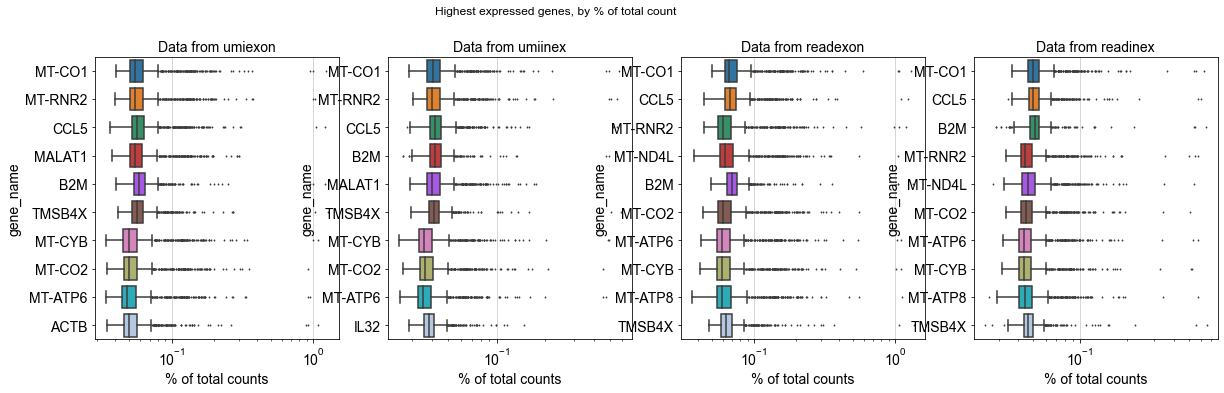

In [27]:
fig,ax = plt.subplots(1,len(datasets), figsize=(20,5))
for j,ds in enumerate(datasets):
    sc.pl.highest_expr_genes(adata[ds], n_top=10, ax=ax[j], log=True, show=False)
    ax[j].set_title('Data from {}'.format(ds))

plt.suptitle('Highest expressed genes, by % of total count', y=1.05)
plt.show()

In [28]:
for ds in datasets:
    adata[ds].var['mt'] = adata[ds].var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata[ds], qc_vars=['mt'], percent_top=None, inplace=True)

In [29]:
hue_order = {'Clone_A':'steelblue', 'Clone_B':'orange', 'Clone_C':'green'}

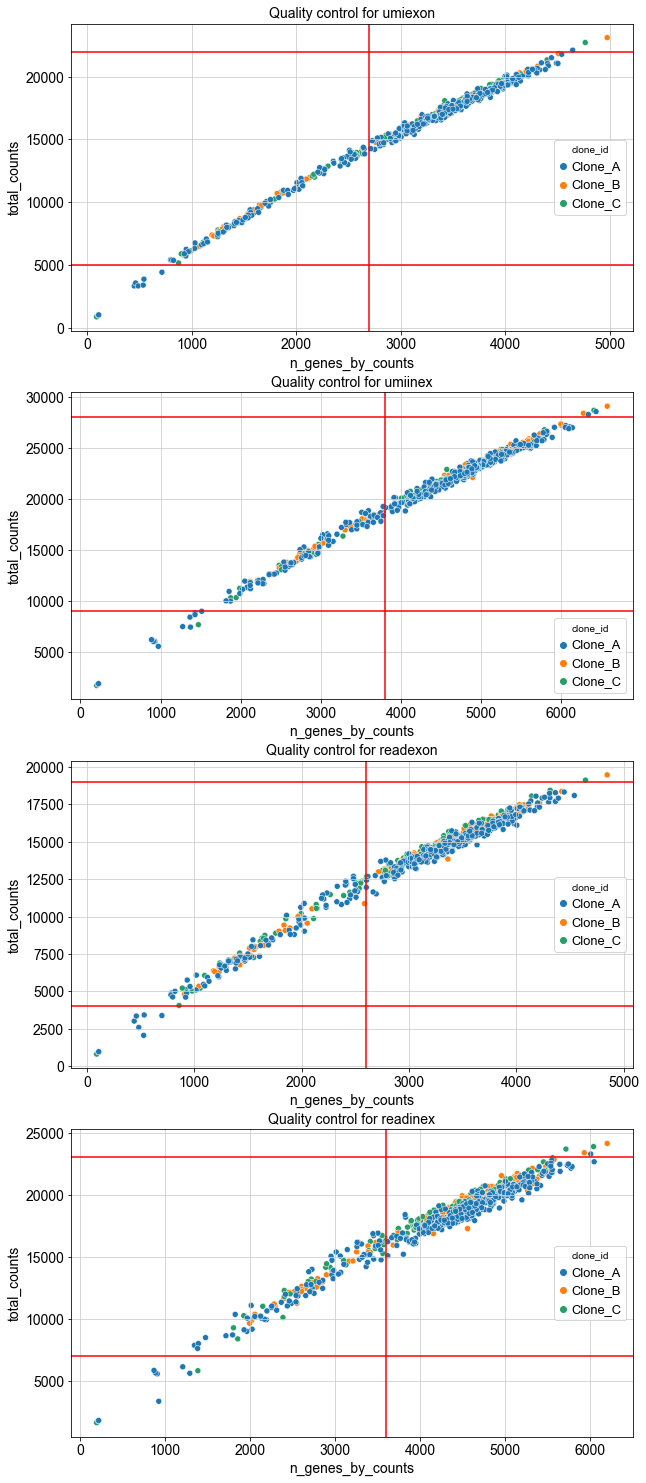

In [33]:
fig,ax = plt.subplots(4,1, figsize=(10,25))
min_counts = {}
max_counts = {}

# The following cutoffs were chosen after plotting!
min_counts['umiexon'] = 5000
min_counts['umiinex'] = 9000
min_counts['readexon'] = 4000
min_counts['readinex'] = 7000
#
max_counts['umiexon'] = 22000
max_counts['umiinex'] = 28000
max_counts['readexon'] = 19000
max_counts['readinex'] = 23000
#
min_gc = {}
min_gc['umiexon'] = 2700
min_gc['umiinex'] = 3800
min_gc['readexon'] = 2600
min_gc['readinex'] = 3600

for j,ds in enumerate(datasets):
    sns.scatterplot(x='n_genes_by_counts', y='total_counts', 
                    data=adata[ds].obs,  hue = 'clone_id', hue_order = hue_order, ax=ax[j])
    ax[j].set_title('Quality control for {}'.format(ds))
    ax[j].axhline(min_counts[ds], color='red')
    ax[j].axvline(min_gc[ds], color='red')
    ax[j].axhline(max_counts[ds], color='red')
plt.show()

In [34]:
for ds in datasets:
    sc.pp.filter_cells(adata[ds], min_counts=min_counts[ds])
    sc.pp.filter_cells(adata[ds], max_counts=max_counts[ds])
    sc.pp.filter_cells(adata[ds], min_genes=min_gc[ds])

In [35]:
adata['umiexon'].obs

,clone_id,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_counts,n_genes
P1P2_cell_94,Clone_B,3194,8.069342,16723.224609,9.724613,110.082428,4.710272,0.658261,16723.224609,3194
P1P2_cell_166,Clone_B,3514,8.164795,17464.226562,9.767967,110.756973,4.716327,0.634193,17464.226562,3514
P1P2_cell_286,Clone_C,3197,8.070281,16427.281250,9.706759,97.630447,4.591380,0.594319,16427.281250,3197
P1P2_cell_382,Clone_C,3220,8.077447,16415.355469,9.706034,107.991562,4.691270,0.657869,16415.355469,3220
P1P2_cell_142,Clone_B,3254,8.087948,16588.449219,9.716522,102.147812,4.636163,0.615777,16588.449219,3254
...,...,...,...,...,...,...,...,...,...,...
P1A03_cell_242,Clone_A,3536,8.171034,17432.607422,9.766155,106.945061,4.681623,0.613477,17432.607422,3536
P1A03_cell_266,Clone_A,3400,8.131825,16996.488281,9.740821,108.931091,4.699854,0.640904,16996.488281,3400
P1A03_cell_290,Clone_A,3637,8.199189,18020.271484,9.799308,109.137741,4.701732,0.605639,18020.271484,3637
P1A03_cell_98,Clone_A,3218,8.076826,16221.704102,9.694167,114.083511,4.745658,0.703277,16221.704102,3218


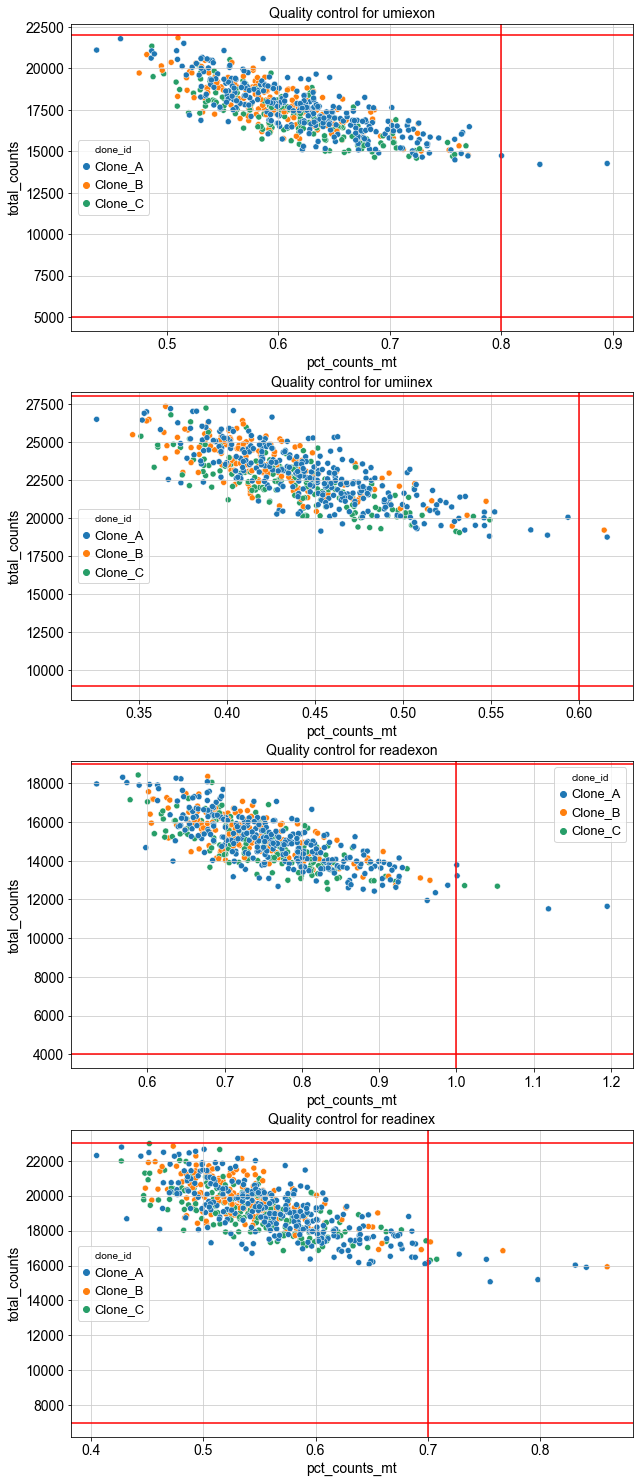

In [36]:
fig,ax = plt.subplots(4,1, figsize=(10,25))

# Set these after looking at plots to filter out cells with too high %MT-genes.
min_MT = {}
min_MT['umiexon'] = 0.8
min_MT['umiinex'] = 0.6
min_MT['readexon'] = 1.0
min_MT['readinex'] = 0.7

for j,ds in enumerate(datasets):
    sns.scatterplot(x='pct_counts_mt', y='total_counts', 
                    data=adata[ds].obs,  hue = 'clone_id', hue_order = hue_order, ax=ax[j])
    ax[j].set_title('Quality control for {}'.format(ds))
    ax[j].axhline(min_counts[ds], color='red')
    ax[j].axvline(min_MT[ds], color='red')
    ax[j].axhline(max_counts[ds], color='red')
plt.show()

Here we filter out cells with too high a percentage of MT-genes among the counts.

In [37]:
for ds in datasets:
    adata[ds] = adata[ds][adata[ds].obs.pct_counts_mt < min_MT[ds], :]

In [38]:
adata['umiexon']

View of AnnData object with n_obs × n_vars = 598 × 10502
    obs: 'clone_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'transcript_length', 'GC_content', 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'log1p'

# Adding cell size information

In [39]:
PMD = pd.read_csv('../Data/Raw/Protein_Meta_Data_InVitro_YF2003_P1A03P1P2.csv', index_col=0, header = 1)
PMD.head()

,Unnamed: 1,Unnamed: 2,Unnamed: 3,FCS 488-200,SSC 488-200,*530/40 488-200,*610/20 488-200,*692/40 488-200,*670/30 640-120,*750 LP 640-120,*520/35 405-100,*460/50 405-100
Sample_ID,Well,Clone_ID,Events,Mean,Mean,Mean,Mean,Mean,Mean,Mean,Mean,Mean
YVF2003clonesP1P2_1,A1,346,1,33483,22072,115,25,46,11,3,1,1
YVF2003clonesP1P2_2,A2,346,1,36494,18666,78,12,34,17,28,6,6
YVF2003clonesP1P2_3,A3,346,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YVF2003clonesP1P2_4,A4,346,1,35185,13247,44,27,26,8,11,4,2


In [40]:
cell_sizes = PMD[['FCS 488-200', 'SSC 488-200']]
cell_sizes = cell_sizes.drop('Sample_ID')
cell_sizes.index = cell_sizes.index.map(rename_cell)
cell_sizes.columns = ['FCS', 'SSC']
cell_sizes = cell_sizes.astype(float)
#cell_sizes = cell_sizes.loc[X.index]
#cell_sizes = cell_sizes.astype(float)
#cell_sizes = cell_sizes.dropna()
cell_sizes.head()

,FCS,SSC
P1P2_cell_1,33483.0,22072.0
P1P2_cell_2,36494.0,18666.0
P1P2_cell_3,NaN,NaN
P1P2_cell_4,35185.0,13247.0
P1P2_cell_5,48275.0,31884.0


In [41]:
for ds in datasets:
    adata[ds].obs['FCS'] = cell_sizes['FCS']
    adata[ds].obs['SSC'] = cell_sizes['SSC']

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [42]:
adata['umiexon'].obs

,clone_id,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_counts,n_genes,FCS,SSC
P1P2_cell_94,Clone_B,3194,8.069342,16723.224609,9.724613,110.082428,4.710272,0.658261,16723.224609,3194,42674.0,21771.0
P1P2_cell_166,Clone_B,3514,8.164795,17464.226562,9.767967,110.756973,4.716327,0.634193,17464.226562,3514,40430.0,26377.0
P1P2_cell_286,Clone_C,3197,8.070281,16427.281250,9.706759,97.630447,4.591380,0.594319,16427.281250,3197,48814.0,15158.0
P1P2_cell_382,Clone_C,3220,8.077447,16415.355469,9.706034,107.991562,4.691270,0.657869,16415.355469,3220,46710.0,19682.0
P1P2_cell_142,Clone_B,3254,8.087948,16588.449219,9.716522,102.147812,4.636163,0.615777,16588.449219,3254,41638.0,17796.0
...,...,...,...,...,...,...,...,...,...,...,...,...
P1A03_cell_242,Clone_A,3536,8.171034,17432.607422,9.766155,106.945061,4.681623,0.613477,17432.607422,3536,36473.0,18515.0
P1A03_cell_266,Clone_A,3400,8.131825,16996.488281,9.740821,108.931091,4.699854,0.640904,16996.488281,3400,44517.0,20909.0
P1A03_cell_290,Clone_A,3637,8.199189,18020.271484,9.799308,109.137741,4.701732,0.605639,18020.271484,3637,45593.0,23799.0
P1A03_cell_98,Clone_A,3218,8.076826,16221.704102,9.694167,114.083511,4.745658,0.703277,16221.704102,3218,40793.0,12715.0


## Summary and saving AnnData Objects

In [43]:
for ds in datasets:
    print('Summary of {} data'.format(ds))
    print(adata[ds])
    print('---------------------------------------')

Summary of umiexon data
AnnData object with n_obs × n_vars = 598 × 10502
    obs: 'clone_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'FCS', 'SSC'
    var: 'transcript_length', 'GC_content', 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'log1p'
---------------------------------------
Summary of umiinex data
AnnData object with n_obs × n_vars = 618 × 12917
    obs: 'clone_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'FCS', 'SSC'
    var: 'transcript_length', 'GC_content', 'gene_name', 'highly_variable', 'highly_variable_rank', 'means

In [44]:
for ds in datasets:
    adata[ds].write_loom('Processed/Big_Invitro_SS3_'+ds+file_suffix)

We examine one of our datasets just to see that everything looks good.

In [45]:
adata['umiexon'].to_df()

gene_name,WASH7P,AL627309.1,RP11-34P13.13,RP4-669L17.10,MTND1P23,MTND2P28,hsa-mir-6723,RP5-857K21.7,MTATP8P1,MTATP6P1,...,BRCC3-1,VBP1-1,RAB39B-1,TMLHE-1,VAMP7,IL9R,AJ271736.10,PRKY,AC010970.2,PSMA6P1
P1P2_cell_94,0.000000,0.000000,0.000000,0.000000,4.124404,6.674312,6.942279,0.000000,5.212176,4.809432,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
P1P2_cell_166,0.000000,0.000000,0.000000,0.000000,0.000000,6.340762,6.836509,3.724365,4.405374,0.000000,...,5.092397,5.092397,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
P1P2_cell_286,4.625372,0.000000,0.000000,0.000000,3.941977,6.004289,6.631745,0.000000,3.941977,0.000000,...,0.000000,5.535765,3.941977,0.000000,5.027565,4.625372,3.941977,0.00000,0.000000,0.000000
P1P2_cell_382,3.907480,0.000000,0.000000,0.000000,0.000000,6.527705,5.969185,0.000000,3.907480,4.590530,...,0.000000,5.836019,0.000000,0.000000,0.000000,4.992608,0.000000,0.00000,0.000000,0.000000
P1P2_cell_142,0.000000,0.000000,0.000000,0.000000,0.000000,5.962059,6.653918,0.000000,4.985512,3.900480,...,0.000000,0.000000,0.000000,4.985512,0.000000,0.000000,0.000000,3.90048,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P1A03_cell_242,0.000000,3.663887,5.252606,3.663887,0.000000,6.412152,6.529752,0.000000,4.344135,3.663887,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,3.663887,0.000000
P1A03_cell_266,0.000000,0.000000,0.000000,0.000000,0.000000,6.157986,6.071167,0.000000,3.696095,0.000000,...,0.000000,4.778021,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
P1A03_cell_290,4.977155,0.000000,0.000000,0.000000,3.611331,6.071161,6.581063,4.290878,3.611331,4.290878,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.611331,0.00000,0.000000,4.290878
P1A03_cell_98,0.000000,0.000000,0.000000,0.000000,3.702090,7.079149,6.896996,0.000000,3.702090,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,3.702090


In [46]:
adata['umiexon'].obs

,clone_id,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_counts,n_genes,FCS,SSC
P1P2_cell_94,Clone_B,3194,8.069342,16723.224609,9.724613,110.082428,4.710272,0.658261,16723.224609,3194,42674.0,21771.0
P1P2_cell_166,Clone_B,3514,8.164795,17464.226562,9.767967,110.756973,4.716327,0.634193,17464.226562,3514,40430.0,26377.0
P1P2_cell_286,Clone_C,3197,8.070281,16427.281250,9.706759,97.630447,4.591380,0.594319,16427.281250,3197,48814.0,15158.0
P1P2_cell_382,Clone_C,3220,8.077447,16415.355469,9.706034,107.991562,4.691270,0.657869,16415.355469,3220,46710.0,19682.0
P1P2_cell_142,Clone_B,3254,8.087948,16588.449219,9.716522,102.147812,4.636163,0.615777,16588.449219,3254,41638.0,17796.0
...,...,...,...,...,...,...,...,...,...,...,...,...
P1A03_cell_242,Clone_A,3536,8.171034,17432.607422,9.766155,106.945061,4.681623,0.613477,17432.607422,3536,36473.0,18515.0
P1A03_cell_266,Clone_A,3400,8.131825,16996.488281,9.740821,108.931091,4.699854,0.640904,16996.488281,3400,44517.0,20909.0
P1A03_cell_290,Clone_A,3637,8.199189,18020.271484,9.799308,109.137741,4.701732,0.605639,18020.271484,3637,45593.0,23799.0
P1A03_cell_98,Clone_A,3218,8.076826,16221.704102,9.694167,114.083511,4.745658,0.703277,16221.704102,3218,40793.0,12715.0


In [47]:
adata['umiexon'].var

,transcript_length,GC_content,gene_name,highly_variable,highly_variable_rank,means,variances,variances_norm,n_cells,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
gene_name,,,,,,,,,,,,,,,,
WASH7P,1560.400000,54.66,WASH7P,False,NaN,1.481723,5.149339,0.497513,396,False,396,2.392552,1.221582,48.302872,1832.694702,7.514088
AL627309.1,2661.000000,64.43,AL627309.1,False,NaN,0.253264,1.295251,0.887571,83,False,83,0.487108,0.396833,89.164491,373.124634,5.924589
RP11-34P13.13,1739.250000,44.96,RP11-34P13.13,False,NaN,0.473890,1.886245,0.649572,186,False,186,1.024986,0.705563,75.718016,785.139282,6.667134
RP4-669L17.10,682.533333,42.38,RP4-669L17.10,False,NaN,0.190601,0.329637,0.310407,107,False,107,0.566802,0.449037,86.031332,434.170258,6.075737
MTND1P23,372.000000,44.35,MTND1P23,False,NaN,0.477807,0.364866,0.124520,333,False,333,1.693398,0.990804,56.527415,1297.142822,7.168690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IL9R,1482.000000,55.82,IL9R,True,3286.0,0.539164,4.499771,1.345592,81,False,81,0.535225,0.428677,89.425587,409.982239,6.018550
AJ271736.10,1188.500000,54.28,AJ271736.10,False,NaN,0.556136,1.023642,0.296015,309,False,309,1.621311,0.963674,59.660574,1241.924072,7.125222
PRKY,1979.600000,44.30,PRKY,False,NaN,0.096606,0.105688,0.212563,68,False,68,0.341509,0.293795,91.122715,261.595764,5.570616
